### Dimensionality Reduction Notebook
#### By Naveen Aggarwal

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### First, let’s load the data

In [2]:
train=pd.read_csv("Train_UWu5bXk.csv")
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### 1. Missing Values
##### checking the percentage of missing values in each variable

In [3]:
train.isnull().sum()/len(train)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

#### we can set a threshold of, say 20%, and remove the variable having more than 20% missing values. 

In [4]:
# saving missing values in a variable
a = train.isnull().sum()/len(train)*100
# saving column names in a variable
variables = train.columns
variable = [ ]
for i in range(0,12):
    if a[i]<=20:   #setting the threshold as 20%
        variable.append(variables[i])
print(variable)

['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']


In [5]:
train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace=True)
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)

##### Let’s first impute the missing values in the Item_Weight column using the median value of the known Item_Weight observations. For the Outlet_Size column, we will use the mode of the known Outlet_Size values to impute the missing values:

##### Let’s check whether all the missing values have been filled:

In [6]:
train.isnull().sum()/len(train)*100

Item_Identifier              0.0
Item_Weight                  0.0
Item_Fat_Content             0.0
Item_Visibility              0.0
Item_Type                    0.0
Item_MRP                     0.0
Outlet_Identifier            0.0
Outlet_Establishment_Year    0.0
Outlet_Size                  0.0
Outlet_Location_Type         0.0
Outlet_Type                  0.0
Item_Outlet_Sales            0.0
dtype: float64

### 2. Low Variance Filter

##### Now let’s calculate the variance of all the numerical variables.

In [7]:
train.var()

Item_Weight                  1.786956e+01
Item_Visibility              2.662335e-03
Item_MRP                     3.878184e+03
Outlet_Establishment_Year    7.008637e+01
Item_Outlet_Sales            2.912141e+06
dtype: float64

#### Applying Low Variance Filter

In [8]:
numeric = train[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']]
var = numeric.var()
numeric = numeric.columns
variable = [ ]
for i in range(0,len(var)):
    if var[i]>=10:   #setting the threshold as 10%
       variable.append(numeric[i])
print(variable)

['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year']


### 3. High Correlation Filter

#### Let’s perform the correlation calculation in Python. We will drop the dependent variable (Item_Outlet_Sales) first and save the remaining variables in a new dataframe (df).


In [9]:
df=train.drop('Item_Outlet_Sales', 1)
df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
Item_Weight,1.000000,-0.014168,0.024951,0.007739
Item_Visibility,-0.014168,1.000000,-0.001315,-0.074834
Item_MRP,0.024951,-0.001315,1.000000,0.005020
Outlet_Establishment_Year,0.007739,-0.074834,0.005020,1.000000


#### we don’t have any variables with a high correlation in our dataset. Generally, if the correlation between a pair of variables is greater than 0.5-0.6, we should seriously consider dropping one of those variables.

### 4. Random Forest

##### We need to convert the data into numeric form by applying one hot encoding, as Random Forest (Scikit-Learn Implementation) takes only numeric inputs. Let’s also drop the ID variables (Item_Identifier and Outlet_Identifier) as these are just unique numbers and hold no significant importance for us currently.

In [10]:
from sklearn.ensemble import RandomForestRegressor
df_new=df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
# By default 100 estimators
model = RandomForestRegressor(random_state=1, max_depth=10)
# To covert into One Hot encoding, pandas method get_dummies is used
df_new=pd.get_dummies(df_new)
model.fit(df_new,train.Item_Outlet_Sales)

RandomForestRegressor(max_depth=10, random_state=1)

#### After fitting the model, plot the feature importance graph:

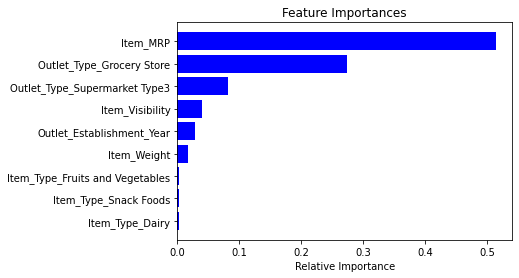

In [11]:
features = df_new.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Based on the above graph, we can hand pick the top-most features to reduce the dimensionality in our dataset. Alernatively, we can use the SelectFromModel of sklearn to do so. It selects the features based on the importance of their weights.

In [12]:
from sklearn.feature_selection import SelectFromModel
feature = SelectFromModel(model)
Fit = feature.fit_transform(df_new, train.Item_Outlet_Sales)

### 5. Backward Elimination Method

In [13]:
from sklearn.datasets import make_friedman1
# Recursive Feature Eliminator
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

In [14]:
# It 
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
print(X.shape)
print(y)
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

(50, 10)
[17.2134918  19.37965436 14.75030901 11.81662128  9.45520588 13.90806032
  3.40447398 24.20228984 17.5783377  17.51556532 17.40999895 17.11893656
 21.81510702 15.88623898 21.63246599 13.01689624 22.908266    6.84202611
 10.32969753 17.70617001  8.52251585  9.51592807 19.81663198  2.99416378
  8.04688453 22.09060713 18.07976383 15.64717616  9.18985112  8.10886643
 11.46237964 11.27510587  9.39472899 19.12963765  6.75303583  8.59450992
 14.08547252 15.47556192 23.37684908 10.65602456 26.21981092  7.56662861
  6.09081028 15.3507226  13.30251573 15.05111884 12.18062778 23.69853054
  7.89988206 14.86941989]
[ True  True  True  True  True False False False False False]
[1 1 1 1 1 6 4 3 2 5]


### 6. Feature Selection method

In [15]:
from sklearn.feature_selection import f_regression
ffs = f_regression(df_new,train.Item_Outlet_Sales )

#### This returns an array containing the F-values of the variables and the p-values corresponding to each F value. . For our purpose, we will select the variables having F-value greater than 10:

In [16]:
variable = [ ]
for i in range(0,len(df.columns)-1):
    if ffs[0][i] >=10:
       variable.append(df.columns[i])
print(variable)

['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Outlet_Location_Type']


### 7. Factor Analysis

In [ ]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(rotation = None,impute = "drop",n_factors=df.shape[1])
fa.fit(df)
ev,_ = fa.get_eigenvalues()
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,dataframe.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()

### 8. Singular Value Deomposition

In [18]:
# Implementation using Numpy
import numpy as np
 
#Creating a matrix A
A = np.array([[3,4,3],[1,2,3],[4,2,1]])
print (A) 
#Performing SVD
U, D, VT = np.linalg.svd(A)
print(U,D,VT) 
#Checking if we can remake the original matrix using U,D,VT
A_remake = (U @ np.diag(D) @ VT)
print(A_remake)


[[3 4 3]
 [1 2 3]
 [4 2 1]]
[[-0.73553325 -0.18392937 -0.65204358]
 [-0.42657919 -0.62196982  0.65664582]
 [-0.52632788  0.76113306  0.37901904]] [7.87764972 2.54031671 0.69958986] [[-0.60151068 -0.61540527 -0.5093734 ]
 [ 0.73643349 -0.18005275 -0.65210944]
 [ 0.30959751 -0.76737042  0.5615087 ]]
[[3. 4. 3.]
 [1. 2. 3.]
 [4. 2. 1.]]


#### In TruncatedSVD we need to specify the number of components we need in our output, so instead of calculating whole decompositions we just calculate the required singular values and trim the rest.

In [19]:
#Importing required modules
import numpy as np
from sklearn.decomposition import TruncatedSVD
 
#Creating array 
A = np.array([[3,4,3],[1,2,3],[4,2,1]])
 
#Fitting the SVD class
trun_svd =  TruncatedSVD(n_components = 2)
A_transformed = trun_svd.fit_transform(A)
 
#Printing the transformed matrix
print("Transformed Matrix:")
print(A_transformed)



Transformed Matrix:
[[ 5.7942733  -0.46723885]
 [ 3.3604414  -1.58000033]
 [ 4.14622666  1.93351902]]


### 8. PCA

In [20]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

#### Download and Load the Data

In [21]:
mnist = fetch_openml('mnist_784')

In [3]:

# These are the images
mnist.data.shape

(70000, 784)

In [12]:
print(mnist.details)
print(mnist.target)

{'id': '554', 'name': 'mnist_784', 'version': '1', 'description_version': '1', 'format': 'ARFF', 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'], 'upload_date': '2014-09-29T03:28:38', 'language': 'English', 'licence': 'Public', 'url': 'https://old.openml.org/data/v1/download/52667/mnist_784.arff', 'file_id': '52667', 'default_target_attribute': 'class', 'tag': ['AzurePilot', 'OpenML-CC18', 'OpenML100', 'study_1', 'study_123', 'study_41', 'study_99', 'vision'], 'visibility': 'public', 'minio_url': 'http://openml1.win.tue.nl/dataset554/dataset_554.pq', 'status': 'active', 'processing_date': '2020-11-20 20:12:09', 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}
0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


In [13]:
# test_size: what proportion of original data is used for test set
train_img, test_img, train_lbl, test_lbl = train_test_split(
    mnist.data, mnist.target, test_size=1/7.0, random_state=0)
print(train_img.shape)
print(test_img.shape)

(60000, 784)
(10000, 784)


In [14]:

scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_img)

# Apply transform to both the training set and the test set.
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

#### Lets  have two PCA with different thresholds

In [23]:
pca = PCA(.95)
pca1=PCA(0.75)

In [24]:
pca.fit(train_img)
pca1.fit(train_img)

PCA(n_components=0.75)

### You can check the numbers of components picked up, Orignally we had 784 components

In [17]:
pca.n_components_

327

In [25]:
pca1.n_components_

101

#### Apply the mapping (transform) to both the training set and the test set. We are having separate training and test set for both PCAS

In [26]:
train_img1 = pca.transform(train_img)
test_img1 = pca.transform(test_img)
train_img2 = pca1.transform(train_img)
test_img2 = pca1.transform(test_img)

#### Step 1: Import the model you want to use

We are using two models for both of our PCA

In [32]:
from sklearn.linear_model import LogisticRegression
logisticRegr1 = LogisticRegression(solver = 'lbfgs')
logisticRegr2 = LogisticRegression(solver = 'lbfgs')

#### Step 2: Make an instance of the Model

In [34]:
logisticRegr1.fit(train_img1, train_lbl)

D:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [35]:
logisticRegr2.fit(train_img2, train_lbl)

D:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [36]:

# Predict for Multiple Observations (images) at Once
logisticRegr1.predict(test_img1[0:10])

array(['0', '4', '1', '2', '4', '7', '7', '1', '1', '7'], dtype=object)

In [37]:
logisticRegr2.predict(test_img2[0:10])

array(['0', '4', '1', '2', '4', '7', '7', '1', '1', '7'], dtype=object)

#### Measuring Model Performance
accuracy (fraction of correct predictions): correct predictions / total number of data points

Basically, how the model performs on new data (test set)

A very small change in accuracy means we can have only 101 components to have an accuracy of 91.41

In [38]:
score = logisticRegr1.score(test_img1, test_lbl)
print(score)

0.9199


In [39]:
score = logisticRegr2.score(test_img2, test_lbl)
print(score)

0.9141
